# Exp4: 基于K-近邻的车牌号识别

## 一、案例简介

图像的智能处理一直是人工智能领域广受关注的一类技术，代表性的如人脸识别与 CT 肿瘤识别，在人工智能落地的进程中发挥着重要作用。其中车牌号识别作为一个早期应用场景，已经融入日常生活中，为我们提供了诸多便利，在各地的停车场和出入口都能看到它的身影。车牌号识别往往分为字符划分和字符识别两个子任务，本案例我们将关注字符识别的任务，尝试用 K-NN 的方法对分割好的字符图像进行自动识别和转化。

## 二、作业说明

### 基本要求
* 完成数据的读入和表示，将图片表示成向量并和 label 对应上；
* 构建 K-NN 模型（可调库）对测试集中的图片进行预测并计算准确率；
* 分析当 K 取不同值时测试准确率的变化。

### 扩展要求
* 分析不同距离度量方式对模型效果的影响；
* 对比平权和加权 K-NN 的效果；
* 分析训练集大小对测试结果的影响。

## 三、数据概览
本次我们使用已经分割好的车牌图片作为数据集，包括数字 0-9、字母 A-Z（不包含 O 和 I）以及省份简称共 65 个类，编号从 0 到 64。数据已经分成了训练集和测试集，里面的文件夹用 label 编号命名，一个文件夹下的所有图片都属于该文件夹对应的类，每个图片都是 20 * 20 的二值化灰度图。

下面演示一下如何借助 PIL 库将图片转化为向量：

In [54]:
from PIL import Image
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
img  # 显示图片

In [55]:
import numpy as np
pixels = np.array(img)  # 转化为 numpy 矩阵
pixels.shape

(20, 20)

## 四、模型构建

In [88]:
import os

def read_data(path, max_num=-1):
    data, label = list(), list()
    for root, dirs, files in os.walk(path):  # 遍历所有文件
        if len(dirs) == 0:  # 到达包含图片的文件夹
            y = root.split(os.path.sep)[-1]  # 文件夹名字（label）
            file_lst = files[:max_num] if max_num > 0 else files
            for f in file_lst:
                img = Image.open(os.path.join(root, f))
                data.append(np.array(img).reshape(-1))  # reshape 成一行作为输入向量
                label.append(y)
    return np.array(data), np.array(label)

In [91]:
PREFIX = './data/'
x_train, y_train = read_data(os.path.join(PREFIX, 'train'))
x_test, y_test = read_data(os.path.join(PREFIX, 'test'))
x_train.shape, y_train.shape, x_test.shape, y_test.shape  # 观察训练与测试数据规模

((15954, 400), (15954,), (4665, 400), (4665,))

In [92]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier()
clf.fit(x_train, y_train)  # 记录训练数据
p_test = clf.predict(x_test)  # 预测测试图片
accuracy = accuracy_score(p_test, y_test)  # 计算准确率
print('accuracy: {:<.4f}'.format(accuracy))

accuracy: 0.6969


### K 的影响

K: 1, accuracy: 0.7168
K: 2, accuracy: 0.7220
K: 3, accuracy: 0.7031
K: 4, accuracy: 0.7074
K: 5, accuracy: 0.6969
K: 6, accuracy: 0.6965
K: 7, accuracy: 0.6956
K: 8, accuracy: 0.6924
K: 9, accuracy: 0.6913


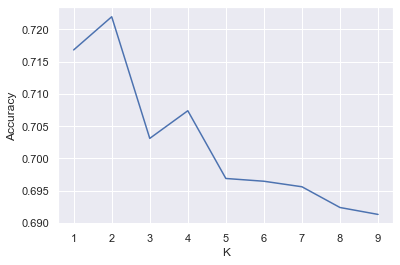

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

k_range = range(1, 10)
acc_lst = list()
for k in k_range:  # 遍历邻居的个数 k
    clf = KNeighborsClassifier(k)
    clf.fit(x_train, y_train)  # 记录训练数据
    p_test = clf.predict(x_test)  # 预测测试图片
    accuracy = accuracy_score(p_test, y_test)  # 计算准确率
    acc_lst.append(accuracy)
    print('K: {}, accuracy: {:<.4f}'.format(k, accuracy))
    
plt.plot(k_range, acc_lst)  # 画图
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

### 是否加权以及距离度量的影响

In [80]:
for weight in ['uniform', 'distance']:
    for metric in ['euclidean', 'manhattan', 'chebyshev', 'minkowski']:
        clf = KNeighborsClassifier(n_neighbors=2, weights=weight, metric=metric)
        clf.fit(x_train, y_train)
        p_test = clf.predict(x_test)
        accuracy = accuracy_score(p_test, y_test)
        acc_lst.append(accuracy)
        print('weight: {}, metric: {}, accuracy: {:<.4f}'.format(weight, metric, accuracy))

weight: uniform, metric: euclidean, accuracy: 0.7220
weight: uniform, metric: manhattan, accuracy: 0.7076
weight: uniform, metric: chebyshev, accuracy: 0.4553
weight: uniform, metric: minkowski, accuracy: 0.7220
weight: distance, metric: euclidean, accuracy: 0.7168
weight: distance, metric: manhattan, accuracy: 0.7145
weight: distance, metric: chebyshev, accuracy: 0.4643
weight: distance, metric: minkowski, accuracy: 0.7168


### 训练集大小的影响

train: 10, accuracy: 0.5633
train: 50, accuracy: 0.6782
train: 100, accuracy: 0.7115
train: 500, accuracy: 0.7196
train: 1000, accuracy: 0.7228
train: 2000, accuracy: 0.7220


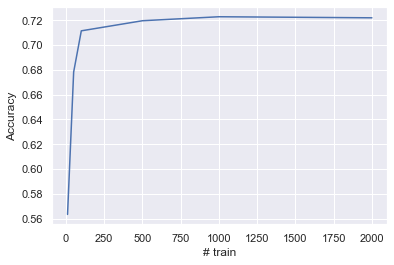

In [95]:
train_range = [10, 50, 100, 500, 1000, 2000]
acc_lst = list()
for train_num in train_range:
    x_train, y_train = read_data(os.path.join(PREFIX, 'train'), max_num=train_num)
    clf = KNeighborsClassifier(2)
    clf.fit(x_train, y_train)
    p_test = clf.predict(x_test)
    accuracy = accuracy_score(p_test, y_test)
    acc_lst.append(accuracy)
    print('train: {}, accuracy: {:<.4f}'.format(train_num, accuracy))

plt.plot(train_range, acc_lst)
plt.xlabel('# train')
plt.ylabel('Accuracy')
plt.show()

## 五、讨论

* 图片表示
    * 二值化
    * 拉伸使字符居中且充满整个区域
    * [方向梯度直方图（HOG）](https://baike.baidu.com/item/HOG/9738560?fr=aladdin)
* 模型
    * 卷积神经网络（CNN）